# Feature engineering

### Libraries

In [18]:
# import libraries

import re

import pandas as pd
import numpy as np

from gensim.models import KeyedVectors
from scipy import stats
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import opinion_lexicon
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import matplotlib.pyplot as plt

### Data

In [19]:
# load review sentiment data

review_df = pd.read_csv('data/review_sentiment.csv')

review_df

,review_id,text,sentiment
0,LLzom-2TITa4gasV7_fCCA,Great experience purchasing a washer and dryer...,1
1,a5JHzBrWxRd_OmIvV7znDA,Went here based on the high ratings and raves ...,-1
2,X-o--dwf0HuFMittYi4wCA,"oh Millers, how i wanted to like you. You are...",-1
3,INGNbsyo-MouZZzcxnCSGQ,This place gets two stars from me only because...,-1
4,k7VatXVLism-cTDJE8TTUw,"This place was awesome. Clean, beautiful and t...",1
...,...,...,...
11681,IlU-MQzMKc7jAHWwK5VFGQ,"To be fair, I tried them in their first week. ...",0
11682,Qt3BsRvQuJccDQfFWM1XPw,Awful place. It's dirty. Had two birthday part...,-1
11683,3CQQ8Im_UX6QqDECuXYK8A,A truly vegetarian delight! I took a Jewish f...,1
11684,ery1nBM7zKweFLBe-bT5ag,I have a 2011 Toyota Sienna Limited. During th...,-1


In [20]:
# load corpus data

corpus = open('data/corpus.txt', 'r').read()
corpus = corpus.split('\n')
corpus = corpus[:-1]

In [21]:
# see contents of corpus

for review in corpus[:5]:
    print('-' * 50)
    print(review)

--------------------------------------------------
great experience purchasing washer dryer bought new home needed new appliance iam glad decided go even though review NOT_great NOT_understand since NOT_issue whatsoever wa excellent selection knowledgeable salesperson timely delivery level service received wa beyond expected ! really felt like working hard give best price offered many option stay budget even took time check additional sale price discount could offer wa given honest feedback question answered happy sears would highly recommend !
--------------------------------------------------
went based high rating raf people entire experience wa underwhelming start finish website fairly useless want figure menu going pick location choice location drill bottom see weak description menu offering NOT_explanation NOT_price roast beef roast beef combo roast pork roast pork combo baked ham baked ham combo roast turkey roast turkey combo broccoli rabe broccoli rabe combo NOT_explanation wh

### Dense embeddings

In [22]:
# load word2vec vectors

wv = KeyedVectors.load("embeddings/reviews_wv")

In [23]:
def text_to_vector(embeddings, text, sequence_len, strategy=None):
    '''
    Function to convert text to word embeddings
    '''
    tokens = text.split()
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True
        finally:
            i += 1
    for _ in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    if strategy == 'mean':
        vec = np.mean(vec, axis=0)
    elif strategy == 'max':
        vec = np.max(vec, axis=0)
    return vec

In [24]:
# corpus statistics

lens = [len(c.split()) for c in corpus]

print('Number of reviews:', len(corpus))
print('Minimum number of words:', np.min(lens))
print('Maximum number of words:', np.max(lens))
print('Average number of words:', np.mean(lens))
print('Standard deviation of words:', np.std(lens))
print('Mode of words:', stats.mode(lens))

Number of reviews: 11686
Minimum number of words: 0
Maximum number of words: 495
Average number of words: 57.83587198357009
Standard deviation of words: 51.51092860825349
Mode of words: ModeResult(mode=19, count=219)


In [25]:
# # convert corpus into dataset with appended embeddings representation

# simple_corpus = []
# for review in review_df['text']:
#     review = re.sub('[^a-zA-Z]', ' ', review).lower()
#     simple_corpus.append(review)

# embeddings_corpus = []
# word_limit = 50
# for review in simple_corpus:
#     embeddings_corpus.append(text_to_vector(wv, review, word_limit))

### Transformations


In [26]:
# BoW

bag_of_words = CountVectorizer()
bow_features = bag_of_words.fit_transform(corpus)

sparse.save_npz('features/bag_of_words.npz', bow_features)

bow_features.shape

(11686, 22373)

In [27]:
# 1-hot encoding

one_hot = CountVectorizer(binary=True)
features = one_hot.fit_transform(corpus)

sparse.save_npz('features/one_hot.npz', features)

features.shape

(11686, 22373)

In [28]:
# N-grams

n_grams = CountVectorizer(ngram_range=(1, 2), max_features=15000)
features = n_grams.fit_transform(corpus)

sparse.save_npz('features/n_grams.npz', features)

features.shape

In [ ]:
# TF-IDF

tf_idf = TfidfVectorizer()
features = tf_idf.fit_transform(corpus)

sparse.save_npz('features/tf_idf.npz', features)

features.shape

(63451, 36470)

In [ ]:
# # Word2Vec

# features = np.array(embeddings_corpus)

# np.save('features/word2vec.npy', features)

# features.shape

Handling negation - lexicons

In [ ]:

nltk.download('opinion_lexicon')

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

# Extend lexicons with NOT_ prefix
extended_positive_words = positive_words.union({'NOT_' + word for word in negative_words})
extended_negative_words = negative_words.union({'NOT_' + word for word in positive_words})

{'fashionable', 'gallantly', 'NOT_wretchedly', 'NOT_freakish', 'cashback', 'NOT_indigent', 'NOT_complication', 'NOT_oppressors', 'NOT_aggression', 'NOT_disaffirm', 'NOT_battered', 'NOT_restricted', 'NOT_impossible', 'charming', 'NOT_layoff', 'NOT_asperse', 'friendliness', 'NOT_sack', 'NOT_expired', 'NOT_shadowy', 'liberate', 'NOT_beware', 'NOT_unforgiving', 'attune', 'NOT_intermittent', 'NOT_dishearten', 'NOT_affront', 'NOT_flawed', 'NOT_mispronounces', 'NOT_tentatively', 'NOT_repulsive', 'NOT_wallow', 'NOT_smoulder', 'NOT_involuntarily', 'NOT_virulent', 'NOT_dishonor', 'NOT_misgivings', 'NOT_rhetorical', 'winning', 'NOT_mocks', 'NOT_distasteful', 'NOT_inflammation', 'NOT_stressfully', 'NOT_disturbed', 'NOT_imposing', 'brilliantly', 'NOT_annoyed', 'endorse', 'NOT_moronic', 'gumption', 'NOT_inappropriately', 'NOT_last-ditch', 'abounds', 'NOT_calumniate', 'NOT_galls', 'NOT_grapple', 'purposeful', 'NOT_exacerbate', 'pampered', 'NOT_straining', 'NOT_aggressive', 'NOT_crook', 'NOT_cackle', 

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /home/lia/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [ ]:
def count_sentiment_words(text, positive_words, negative_words):
    words = text.split()
    pos_count = sum(1 for word in words if word in positive_words)
    neg_count = sum(1 for word in words if word in negative_words)
    return pos_count, neg_count



In [ ]:

pos_counts = []
neg_counts = []
for review in corpus:
    pos_count, neg_count = count_sentiment_words(review, positive_words, negative_words)
    print(f"Positive words: {pos_count}, Negative words: {neg_count}")
    pos_counts.append(pos_count)
    neg_counts.append(neg_count)

# Convert to numpy arrays
pos_counts = np.array(pos_counts).reshape(-1, 1)
neg_counts = np.array(neg_counts).reshape(-1, 1)

sentiment_features = np.hstack((pos_counts, neg_counts))
sentiment_features_sparse = sparse.csr_matrix(sentiment_features)

# Combine the sparse matrices
combined_features = sparse.hstack([bow_features, sentiment_features_sparse])
sparse.save_npz('features/combined_features', combined_features)

print(combined_features.shape)

Positive words: 4, Negative words: 0
Positive words: 0, Negative words: 1
Positive words: 10, Negative words: 9
Positive words: 3, Negative words: 0
Positive words: 2, Negative words: 0
Positive words: 1, Negative words: 2
Positive words: 2, Negative words: 1
Positive words: 2, Negative words: 1
Positive words: 8, Negative words: 9
Positive words: 2, Negative words: 0
Positive words: 0, Negative words: 0
Positive words: 0, Negative words: 0
Positive words: 10, Negative words: 1
Positive words: 3, Negative words: 0
Positive words: 3, Negative words: 2
Positive words: 3, Negative words: 0
Positive words: 2, Negative words: 2
Positive words: 2, Negative words: 0
Positive words: 12, Negative words: 3
Positive words: 9, Negative words: 2
Positive words: 1, Negative words: 1
Positive words: 4, Negative words: 1
Positive words: 4, Negative words: 4
Positive words: 3, Negative words: 1
Positive words: 8, Negative words: 0
Positive words: 22, Negative words: 10
Positive words: 8, Negative words

## Topic Modelling

#### with LSA (Latent Semantic Analysis)

In [ ]:
def get_keys(topic_matrix):
    '''
    returns a list of predicted topic categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys): 
    '''
    returns a tuple of topic categories and their magnitudes'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
n_topics = 8

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(bow_features)

lsa_keys = get_keys(lsa_topic_matrix) #list of predicted topic categories
lsa_categories, lsa_counts = keys_to_counts(lsa_keys) #tuple of categories and their magnitudes

In [ ]:
# Get top words for each topic
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
#
top_n_words_lsa = get_top_n_words(10, lsa_keys, bow_features, bag_of_words)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  food place good great time order servic get like go
Topic 2:  call would told car room day said get time back
Topic 3:  order wait food minut time ask servic get got call
Topic 4:  cream ice flavor chicken like good chees sauc tast tri
Topic 5:  room hotel stay staff clean nice bed night would one
Topic 6:  place love order staff great go pizza best amaz loui
Topic 7:  good food place like get price pretti realli seat blah
Topic 8:  food love best amaz loui delici st flavor restaur chicken


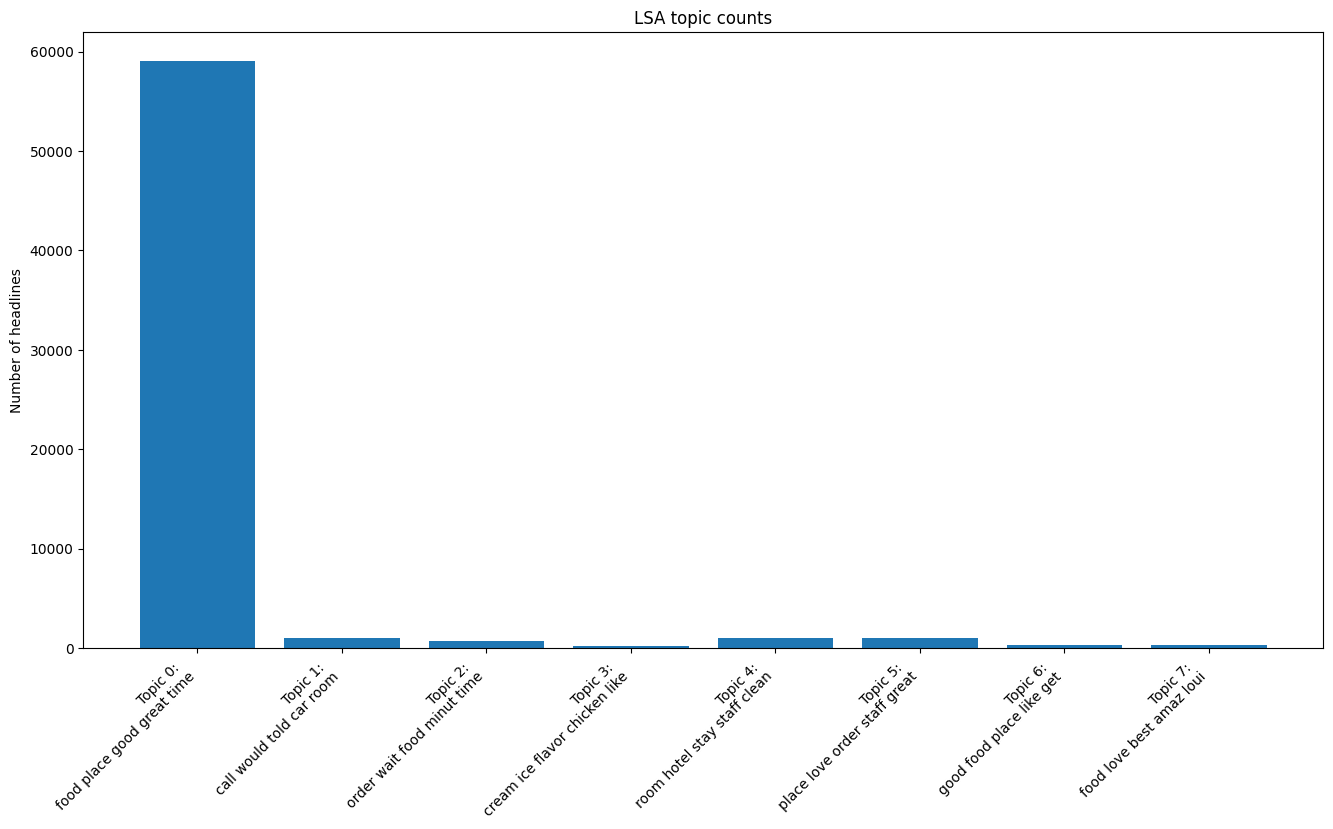

In [ ]:
top_5_words = get_top_n_words(5, lsa_keys, bow_features, bag_of_words)
labels = ['Topic {}: \n'.format(i) + top_5_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Number of headlines')
ax.set_title('LSA topic counts')
plt.show()

#### with LDA (Latent Dirichilet Allocation)

In [ ]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(bow_features)

In [ ]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [ ]:
top_n_words_lda = get_top_n_words(10, lda_keys, bow_features, bag_of_words)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  store locat one go get shop time item like alway
Topic 2:  room hotel stay one would clean staff night get bed
Topic 3:  good order food chicken fri sauc great like chees tri
Topic 4:  food place good like great time get go one order
Topic 5:  order time food get wait servic would back us ask
Topic 6:  time servic would work get great call car day need
Topic 7:  great food place good love servic delici tri back amaz
Topic 8:  pizza beer great game bar place good drink love food


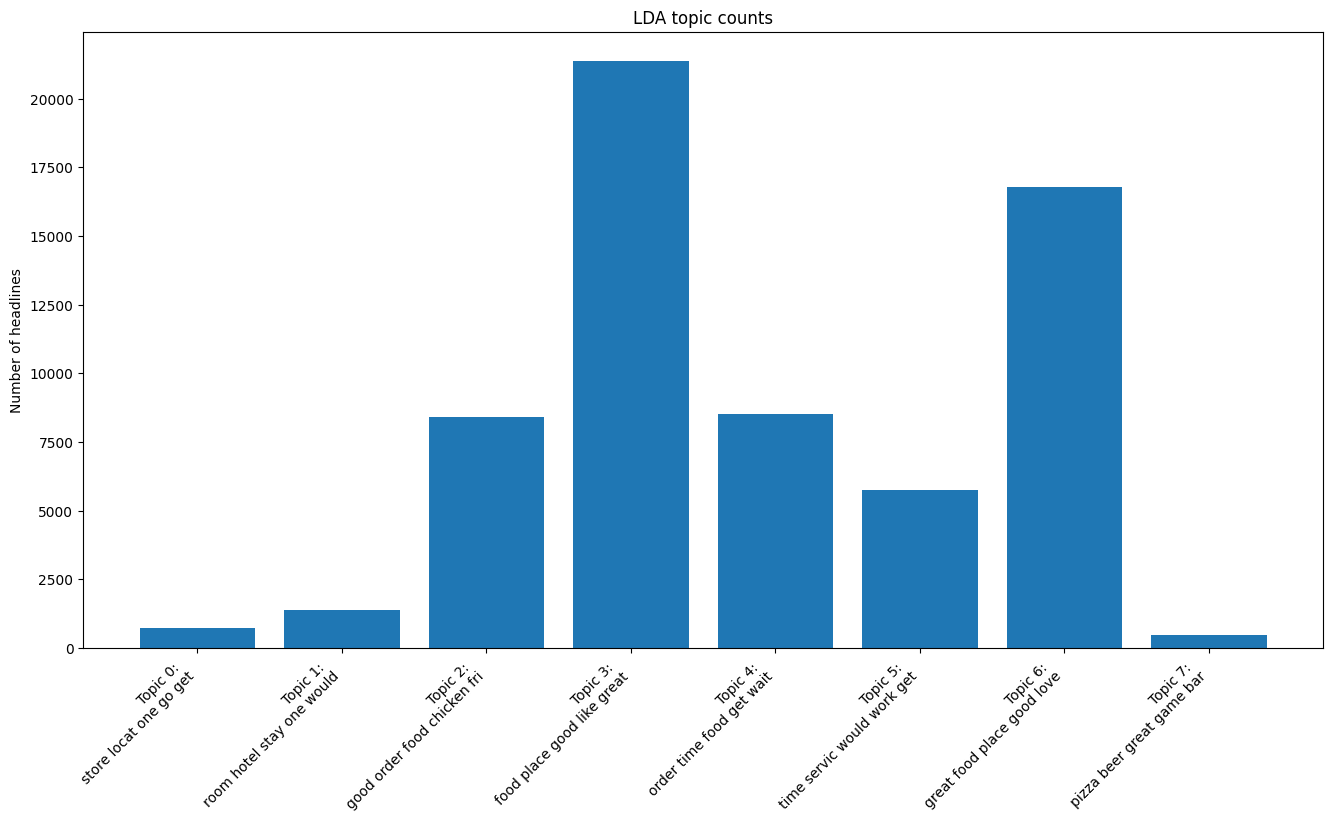

In [ ]:
top_5_words = get_top_n_words(5, lda_keys, bow_features, bag_of_words)
labels = ['Topic {}: \n'.format(i) + top_5_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of headlines')
plt.show()